#### Implementazione di un classificatore basato su algoritmi tree-based addestrato su ddm_raw_counts con l'obiettivo di distinguere terra da acqua.


COME FILTRARE DATI DI RONGOWAI:

per ciascun file, mantenere DDM, variabile raw_counts, tali che:
	- SNR > 0db (ddm_snr)
	- Nadir antenna gain LHCP/RHCP > 5db (sp_rx_gain_copol, sp_rx_gain_xpol, ddm_antenna)
	- distanza dell'antenna dal punto speculare tra 2 e 10km (calcolata come nel notebook)

ogni DDM è caratterizzata da:
	- nome del file (filename.nc)
	- numero del campione nel file (es. da 1 a 4000)
	- numero del canale nel campione (da 1 a 20)

salviamo in un file di testo, uno per riga, il nome di ciascuna DDM che vogliamo tenere e la sua etichetta:
	filename_campione_canale + etichetta mare/terra

usiamo questa lista per creare i batch per il training dei modelli

In [53]:
import warnings
warnings.filterwarnings('ignore')

In [54]:
import netCDF4

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm
from shapely.geometry import Point
from sklearn.decomposition import PCA
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import pycaret

import seaborn as sns



import warnings
warnings.filterwarnings("ignore")
from datetime import timezone
UTC = timezone.utc

### Data import

In [55]:
# add seconds to a timestamp
def add_seconds(time, seconds):
    timestamp = datetime.strptime(time, "%Y-%m-%d %H:%M:%S")
    new_timestamp = timestamp + timedelta(seconds=seconds)
    return new_timestamp.strftime("%Y-%m-%d %H:%M:%S")

In [56]:

# list netcdf files
import os

netcdf_file_list = os.listdir('./sample_data/')

f = netCDF4.Dataset(f'./sample_data/{netcdf_file_list[3]}')

ddm_variables = [var for var in f.variables.keys() if 'ddm' in var] + ['raw_counts','brcs','eff_scatter','surface_reflectivity','sp_surface_type'] # variables related to DDMs (a rough selection)



In [57]:
specular_point_lat = f.variables['sp_lat'][:]
specular_point_lon = f.variables['sp_lon'][:]

In [58]:
lat_lon_pairs = {
    'Aircraft': (f.variables['ac_lat'][:], f.variables['ac_lon'][:]),
    'Average DDM Specular Point': (np.nanmean(specular_point_lat, axis=1), np.nanmean(specular_point_lon, axis=1)),
    'Single DDM Specular Point': (np.compress(~np.isnan(np.array(specular_point_lat).ravel()), np.array(specular_point_lat).ravel()),
                                  np.compress(~np.isnan(np.array(specular_point_lon).ravel()), np.array(specular_point_lon).ravel())),
}

In [59]:
# Carica il dataset delle terre emerse (Natural Earth) https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
world = gpd.read_file("./data/land_vs_water_country_borders/ne_110m_admin_0_countries.shp")
lats = np.array(lat_lon_pairs['Aircraft'][0])
lons = np.array(lat_lon_pairs['Aircraft'][1])

def is_land(lat, lon):
    """Restituisce True se il punto è su terra, False se è in mare/oceano"""
    point = Point(lon, lat)  # Geopandas usa (lon, lat), non (lat, lon)
    return any(world.contains(point))

In [60]:
# DDM specular point surface types
from collections import Counter

print(f.variables["sp_surface_type"])

surface_type_dict = {
    -1:"Ocean",
    0:"NaN",
    1:"Artifical",
    2:"Barely vegetated",
    3:"Inland water",
    4:"Crop",
    5:"Grass",
    6:"Shrub",
    7:"Forest"
}

# Conteggio delle occorrenze
surface_types = f.variables["sp_surface_type"][:]
surface_types = np.nan_to_num(surface_types, nan=0)
counts = Counter(np.array(surface_types).ravel())
surface_type_labels = list(counts.keys())
freqs = list(counts.values())

<class 'netCDF4.Variable'>
float32 sp_surface_type(sample, ddm)
    units: 1
    long_name: Surface type of the specular point
    comment: Surface type of the specular point, surface type from the latest LINZ database, where
-1 = ocean, 1 = artifical, 2 = barely vegetated, 3 = inland water, 4 = crop, 5 = grass, 6 = shrub, 7 = forest
unlimited dimensions: sample, ddm
current shape = (2746, 20)
filling on, default _FillValue of 9.969209968386869e+36 used


In [61]:
# Check whether a group of 20 DDMs has at least one ocean and one land point
def check_ocean_and_land(lst):
    has_ocean = -1 in lst
    has_land = any(1 <= num <= 7 for num in lst)
    #if has_ocean and has_land:
    #    print(f"Sample {lst} has at least one ocean and one land point")
    return has_ocean and has_land

samples_have_ocean_and_land = [check_ocean_and_land(lst) for lst in surface_types]

In [62]:
ddm_antennas = {
    0: 'None',
    1: 'Zenith',
    2: 'LHCP',
    3: 'RHCP',
}

# Aircraft position
lats = np.array(lat_lon_pairs['Aircraft'][0])
lons = np.array(lat_lon_pairs['Aircraft'][1])

data = f.variables["ddm_snr"][:,0]
np.count_nonzero(data > 0), np.count_nonzero(data <= 0), data.size, np.count_nonzero(np.isnan(data))

(942, 1602, 2746, 202)

In [ ]:
#a_few_land_points = np.random.choice([i for i, val in enumerate([is_land(lat, lon) for lat, lon in zip(lats, lons)]) if val], 5)
#a_few_water_points = np.random.choice([i for i, val in enumerate([is_land(lat, lon) for lat, lon in zip(lats, lons)]) if not val], 5)
#amples = [int(i) for i in np.concatenate((a_few_land_points, a_few_water_points))]

## Extracting and plotting DDMs
#raw_counts = f.variables['raw_counts']
##raw_counts = np.array(raw_counts)


NameError: name 's' is not defined

In [ ]:
#f.variables['raw_counts']

<class 'netCDF4.Variable'>
uint32 raw_counts(sample, ddm, delay, doppler)
    units: 1
    long_name: DDM bin raw counts
    comment: 5 x 40 array of DDM bin raw counts multiplies the first scale factor. These are the uncalibrated power values produced by the NGRx.
unlimited dimensions: sample, ddm, delay, doppler
current shape = (2746, 20, 40, 5)
filling on, default _FillValue of 4294967295 used

### Fill nans and clean

In [64]:
raw_counts = f.variables['raw_counts']
raw_counts = np.array(raw_counts)

In [65]:
# Funzione per riempire, data la matrice totale (N, M, P, Q), per ogni campione N, le matrici (P, Q) completamente NaN con la media delle matrici (M, P, Q) non nulle
# Se tutte e M le matrici sono nulle, scarto il campione
def fill_and_filter(arr):
    mask_all_nan = np.all(np.isnan(arr), axis=(2, 3))  # Shape (N, M), True se la matrice è tutta NaN

    arr_filled = arr.copy()  # Facciamo una copia per non modificare l'originale

    for i in range(arr.shape[0]):  # Iteriamo sui campioni
        nan_indices = np.where(mask_all_nan[i])[0]  # Indici delle matrici M completamente NaN
        if len(nan_indices) > 0:  
            # Troviamo una matrice valida da cui prendere la media
            valid_indices = np.where(~mask_all_nan[i])[0]  
            if len(valid_indices) > 0:
                mean_matrix = np.nanmean(arr[i, valid_indices, :, :], axis=0)  # Media sulle matrici valide
                arr_filled[i, nan_indices, :, :] = mean_matrix  # Riempimento
            # Se tutte le matrici M di un campione sono NaN, lo segneremo per l'eliminazione

    # Identificare i campioni da eliminare (se TUTTE le matrici M sono NaN)
    mask_discard = np.all(mask_all_nan, axis=1)  
    arr_filtered = arr_filled[~mask_discard]  # Manteniamo solo i campioni validi

    return arr_filtered, list(np.where(mask_discard.astype(int) == 1)[0])

In [ ]:
raw_counts = f.variables['raw_counts']
raw_counts = np.array(raw_counts)

# Calcolo distanza tra il punto speculare e l'aereo
ac_alt_2d = np.repeat(np.array(f.variables['ac_alt'])[:, np.newaxis], 20, axis=1)
distance_2d = (ac_alt_2d - f.variables['sp_alt'][:]) / np.cos(np.deg2rad(f.variables['sp_inc_angle'][:]))

# Seleziona gli indici dove sp_rx_gain_copol > 5, sp_rx_gain_xpol > 5 e ddm_snr > 0 e distanza tra punto speculare e antenna > 2000 e < 10000
copol = f.variables['sp_rx_gain_copol'][:]
xpol = f.variables['sp_rx_gain_xpol'][:]
snr = f.variables['ddm_snr'][:]
dist = distance_2d[:]

keep_mask = (copol >= 5) & (xpol >= 5) & (snr > 0) & ((dist >= 2000) & (dist <= 10000)) & (~np.isnan(copol.data) & ~np.isnan(xpol.data) & ~np.isnan(snr.data) & ~np.isnan(dist.data))
to_keep_indices = np.argwhere(keep_mask)
discard_indices =  np.argwhere(~keep_mask)


filtered_raw_counts = [raw_counts[i, j] for i, j in to_keep_indices]
filtered_raw_counts_arr = np.array(filtered_raw_counts)

raw_counts_shape = raw_counts.shape
output_array = np.full(raw_counts_shape, np.nan, dtype=np.float32)

# Inserisci i dati filtrati nelle posizioni di to_keep_indices
for idx, (i, j) in enumerate(to_keep_indices):
    output_array[i, j] = filtered_raw_counts[idx]

raw_counts_filtered = output_array.copy()

ddm_data_dict = {
    #'L1a Power DDM': l1a_power_ddm,
    #'BRCS': brcs,
    'Raw_Counts': raw_counts_filtered.reshape(raw_counts_filtered.shape[0]*raw_counts_filtered.shape[1], raw_counts_filtered.shape[2], raw_counts_filtered.shape[3]),
    #'Effective Scatter': eff_scatter,
    #'Surface Reflectivity': surface_reflectivity
}
keep_indices = np.where(
    np.all(~np.isnan(ddm_data_dict['Raw_Counts']), axis=(1, 2)) & (np.sum(ddm_data_dict['Raw_Counts'], axis=(1, 2)) > 0)
)[0] # remove nan ddms and ddms which are all zeros (esp. for raw counts)
fit_data = np.array([ddm_data_dict['Raw_Counts'][f].ravel() for f in keep_indices])

surface_types = f.variables["sp_surface_type"][:]
surface_types = np.nan_to_num(surface_types, nan=0)

surface_types_unravelled = surface_types.ravel()

# Land vs Water labels (same for all variables)
label_data = [1 if surface_type in np.arange(1,8) else 0 for surface_type in surface_types_unravelled]
label_data = [label_data[l] for l in range(len(label_data)) if l in keep_indices]


### Model search and selection using PyCaret

In [50]:
model_search = True

import os
os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"

if model_search:
    scaler = MinMaxScaler()
    fit_data_scaled, discard_indices = fill_and_filter(ddm_data_dict['Raw_Counts'])
    fit_data_scaled = fit_data_scaled.reshape(fit_data_scaled.shape[0], -1)
    fit_data_scaled = scaler.fit_transform(fit_data_scaled)


    # Land vs Water labels (same for all variables)
    label_data = [1 if is_land(lat, lon) else 0 for lat, lon in zip(lats, lons)]
    label_data = [label_data[l] for l in range(len(label_data)) if l not in discard_indices]


    from pycaret.classification import *
    clf = setup(data=fit_data_scaled, 
            target=label_data, 
            pca=True,
            pca_method='incremental',
            use_gpu=True    
            )             

    # Confronto di vari modelli
    best_models = compare_models(n_select=5)  # Seleziona i 5 migliori modelli

    # Estrazione del modello migliore
    best_model = best_models[0]
    print(f"Il modello migliore è: {best_model}")

    # Tuning degli iperparametri per il modello migliore
    tuned_model = tune_model(best_model, 
                            optimize='Accuracy',     
                            n_iter=10,          
                            search_library='optuna', 
                            search_algorithm='tpe', 
                            choose_better=True)    

    print("Valutazione del modello ottimizzato:")
    evaluate_model(tuned_model)

    # Stampa i parametri migliori del modello
    best_params = tuned_model.get_params()
    print("Migliori iperparametri trovati:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    # Finalizzazione del modello
    final_model = finalize_model(tuned_model)

    # Salvataggio del modello
    save_model(final_model, 'best_classification_model')

    # Per caricare il modello in futuro:
    # loaded_model = load_model('best_classification_model')


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA RTX A500 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that 

,Description,Value
0,Session id,4191
1,Target,target
2,Target type,Binary
3,Original data shape,"(1175, 4001)"
4,Transformed data shape,"(1175, 823)"
5,Transformed train set shape,"(822, 823)"
6,Transformed test set shape,"(353, 823)"
7,Numeric features,4000
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA RTX A500 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9745,0.9963,0.9766,0.9945,0.9853,0.8854,0.8898,2.6590
ridge,Ridge Classifier,0.9684,0.9917,0.9876,0.9770,0.9822,0.8418,0.8466,2.5670
lr,Logistic Regression,0.9647,0.9915,0.9848,0.9756,0.9801,0.8242,0.8273,3.2850
xgboost,Extreme Gradient Boosting,0.9599,0.9811,0.9862,0.9690,0.9774,0.7960,0.8026,4.2860
lightgbm,Light Gradient Boosting Machine,0.9587,0.9810,0.9876,0.9665,0.9769,0.7832,0.7901,7.7770
catboost,CatBoost Classifier,0.9575,0.9827,0.9917,0.9615,0.9763,0.7681,0.7798,58.9050
svm,SVM - Linear Kernel,0.9562,0.9864,0.9766,0.9741,0.9752,0.7855,0.7887,2.5710
ada,Ada Boost Classifier,0.9550,0.9714,0.9848,0.9650,0.9748,0.7664,0.7730,5.9670
gbc,Gradient Boosting Classifier,0.9197,0.9335,0.9448,0.9638,0.9540,0.6336,0.6387,21.2620
qda,Quadratic Discriminant Analysis,0.8869,0.8385,0.9917,0.8922,0.9392,0.1458,0.2127,3.3720


Il modello migliore è: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9759,1.0000,0.9726,1.0000,0.9861,0.8953,0.9003
1,0.9759,0.9945,0.9726,1.0000,0.9861,0.8953,0.9003
2,0.9756,0.9985,0.9863,0.9863,0.9863,0.8752,0.8752
3,0.9512,0.9939,0.9589,0.9859,0.9722,0.7725,0.7776
4,0.9512,0.9939,0.9726,0.9726,0.9726,0.7504,0.7504
5,0.9878,1.0000,0.9861,1.0000,0.9930,0.9454,0.9468
6,0.9390,0.9944,0.9306,1.0000,0.9640,0.7657,0.7876
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9878,0.9986,1.0000,0.9863,0.9931,0.9405,0.9422


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Valutazione del modello ottimizzato:


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Migliori iperparametri trovati:
algorithm: auto
leaf_size: 30
metric: minkowski
metric_params: None
n_jobs: -1
n_neighbors: 5
p: 2
weights: uniform
Transformation Pipeline and Model Successfully Saved


In [ ]:
arr = np.full((1, 4000), -100)

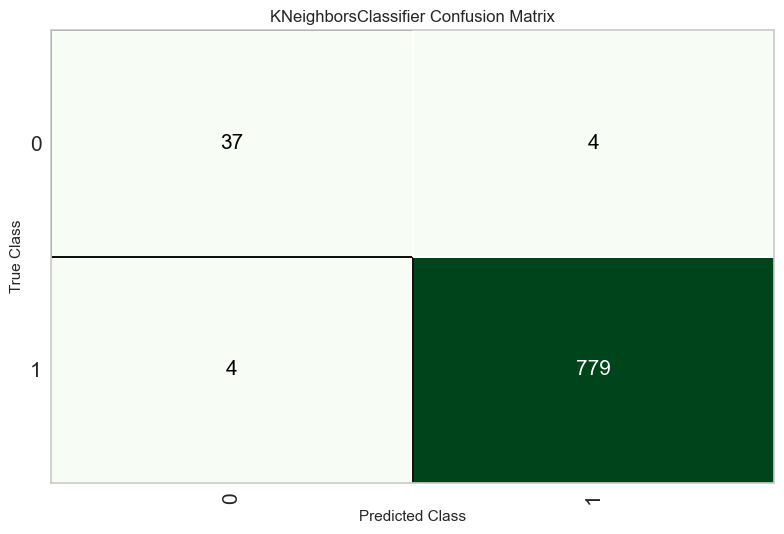

In [21]:
 # Interpretabilità del modello
    #plot_model(tuned_model, plot='feature')  # Importanza delle feature
plot_model(tuned_model, plot='confusion_matrix')  # Matrice di confusione
    #try:
    #    plot_model(tuned_model, plot='auc')  # Curva ROC
    #except:
        # Se il modello non supporta la curva ROC, gestisci l'eccezione
    #    print("Il modello non supporta la curva ROC.")

    #plot_model(tuned_model, plot='pr')   # Precision-Recall

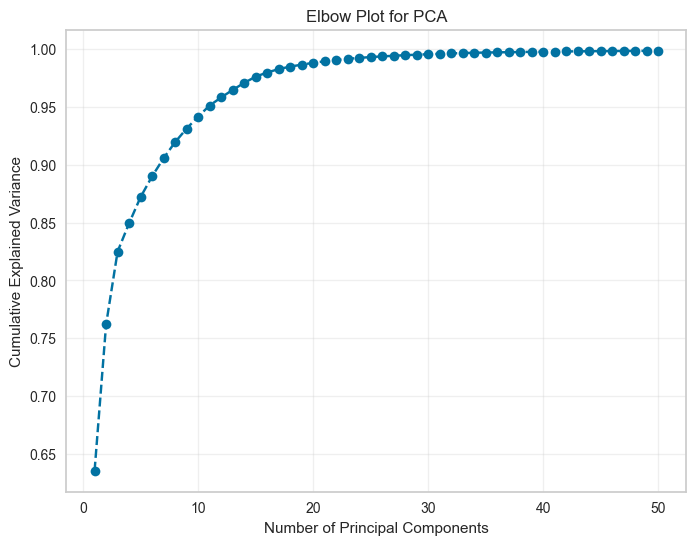

In [51]:
explained_variance = []
components = range(1, min(fit_data.shape[1], 50) + 1) 

for n in components:
    pca = PCA(n_components=n)
    pca.fit(fit_data)
    explained_variance.append(sum(pca.explained_variance_ratio_))
    
plt.figure(figsize=(8, 6))
plt.plot(components, explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Plot for PCA')
plt.grid(alpha=0.3)
plt.show()